In [1]:
import sys
sys.path.insert(0, '../../')

import pandas as pd
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../../ESC-50/audio/'

In [5]:
path_to_db='../../../ESC-50/'

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True,
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = librosa.resample(y, sr, SR)
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
train_X, train_y = load_audio_blockwise(dataset[dataset.fold != 1], orig_blocksize, orig_overlap)
print(train_X.shape)

	Processing Time: 256.7064847946167
(1600, 1, 80000)


In [12]:
test_X, test_y = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)
print(test_X.shape)

	Processing Time: 66.81805610656738
(400, 1, 80000)


## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=SR,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [14]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net,
                       epochs=epochs, 
                       batch_size=batch, 
                       validation_split=0.15)

history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 313, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 305, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 17, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                69664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

1360/1360 [==============================] - 39s 29ms/step - loss: 0.2395 - acc: 0.9059 - mean_absolute_error: 0.1583 - val_loss: 0.7595 - val_acc: 0.7542 - val_mean_absolute_error: 0.2659
Epoch 33/100
1360/1360 [==============================] - 38s 28ms/step - loss: 0.2122 - acc: 0.9206 - mean_absolute_error: 0.1446 - val_loss: 1.0172 - val_acc: 0.7500 - val_mean_absolute_error: 0.2637
Epoch 34/100
1360/1360 [==============================] - 38s 28ms/step - loss: 0.2140 - acc: 0.9191 - mean_absolute_error: 0.1357 - val_loss: 0.9421 - val_acc: 0.7583 - val_mean_absolute_error: 0.2579
Epoch 35/100
1360/1360 [==============================] - 38s 28ms/step - loss: 0.1883 - acc: 0.9272 - mean_absolute_error: 0.1242 - val_loss: 0.9257 - val_acc: 0.7375 - val_mean_absolute_error: 0.2653
Epoch 36/100
1360/1360 [==============================] - 39s 29ms/step - loss: 0.1923 - acc: 0.9213 - mean_absolute_error: 0.1255 - val_loss: 0.7055 - val_acc: 0.8000 - val_mean_absolute_error: 0.2469
Epo

Epoch 73/100
1360/1360 [==============================] - 39s 29ms/step - loss: 0.0769 - acc: 0.9794 - mean_absolute_error: 0.0352 - val_loss: 1.8312 - val_acc: 0.7542 - val_mean_absolute_error: 0.2418
Epoch 74/100
1360/1360 [==============================] - 38s 28ms/step - loss: 0.1075 - acc: 0.9691 - mean_absolute_error: 0.0450 - val_loss: 1.3780 - val_acc: 0.7958 - val_mean_absolute_error: 0.2135
Epoch 75/100
1360/1360 [==============================] - 39s 28ms/step - loss: 0.0574 - acc: 0.9838 - mean_absolute_error: 0.0371 - val_loss: 1.1983 - val_acc: 0.8083 - val_mean_absolute_error: 0.1971
Epoch 76/100
1360/1360 [==============================] - 38s 28ms/step - loss: 0.0546 - acc: 0.9824 - mean_absolute_error: 0.0339 - val_loss: 1.0857 - val_acc: 0.8292 - val_mean_absolute_error: 0.1835
Epoch 77/100
1360/1360 [==============================] - 39s 28ms/step - loss: 0.0501 - acc: 0.9801 - mean_absolute_error: 0.0332 - val_loss: 1.5504 - val_acc: 0.8000 - val_mean_absolute_erro

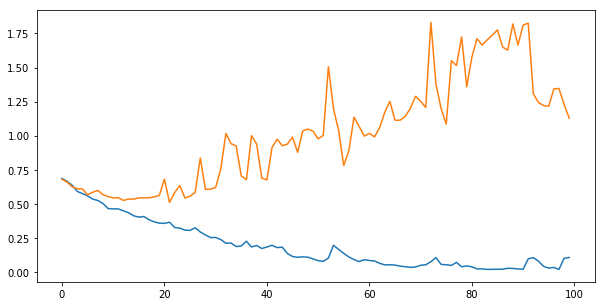

In [23]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

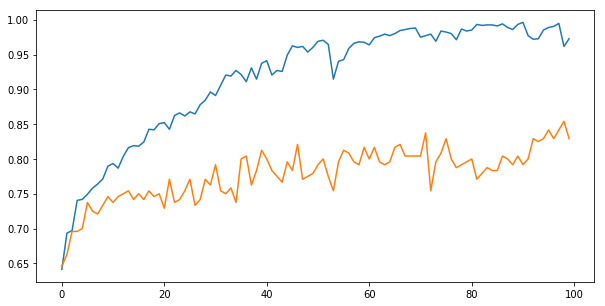

In [24]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7725
Confusion matrix, without normalization
[[105  47]
 [ 44 204]]


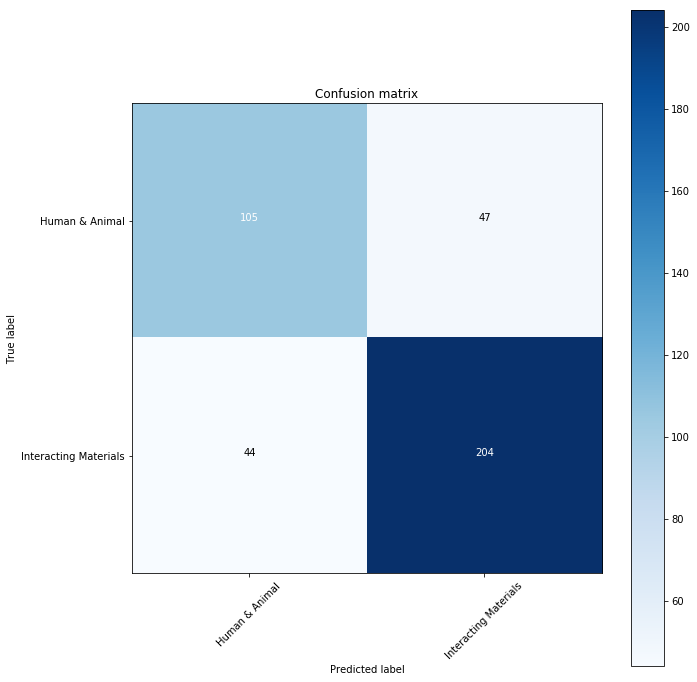

In [25]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [18]:
X, y = load_audio_blockwise(dataset[dataset.fold == 1], orig_blocksize, orig_overlap)

	Processing Time: 63.62871074676514


0.7725
Confusion matrix, without normalization
[[105  47]
 [ 44 204]]


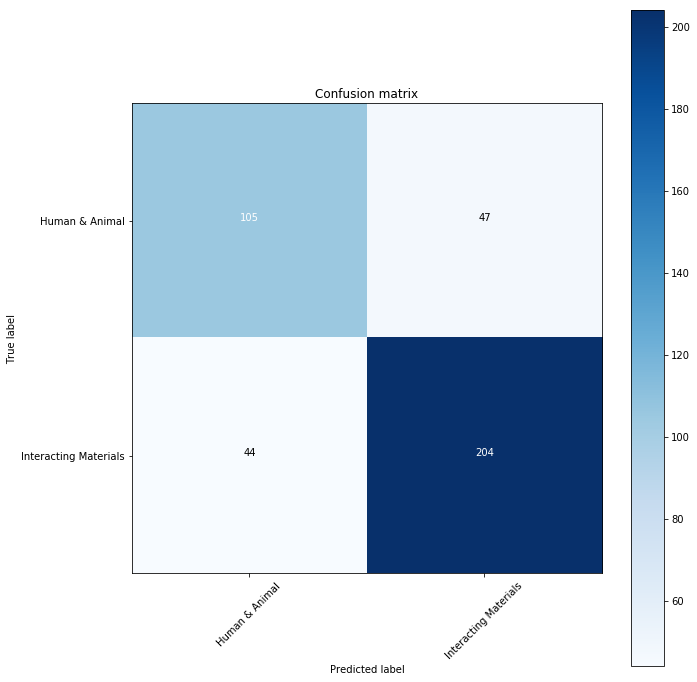

In [19]:
pred = clas.predict(X)
pred_prob = clas.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [20]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for p, prob, Y in zip(pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [21]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.929008,0.070992
Interacting Materials,0.059374,0.940626


In [22]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.959241,0.040759
Interacting Materials,0.022084,0.977916
